<a name="top"> <h1>01.Explanatory Data Analisis and Variable Selection </h1> <a>

<p>Geospatial Analysis of the 2023 Earthquakes in Turkey<br />
<strong>Master Thesis</strong><br />
<strong>Master of Data Science</strong></p>


<p style="text-align:right">Gozde Yazganoglu (<em>gozde.yazganoglu@cunef.edu</em>)</p>

Importing Libraries

In [59]:
import pandas as pd
import sweetviz as sv
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle   
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
import contextily as ctx
import fiona



In [2]:
data = gpd.read_file('../data/processed/dataset.geojson')

data.head()

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,real,...,fertility,hh_size,longitude,latitude,nearest_water_source_distance,nearest_camping_distance,nearest_earthquake_distance,nearest_fault_distance,elev,geometry
0,11-Residential Buildings,Unknown,997-Not Applicable,No visible damage,Photo-interpretation,Building block,1,3,Not Applicable,Not Applicable,...,2.36,4.0,38.314252,37.768867,0.077874,0.020232,0.097845,0.016935,660.0,POINT (38.31425 37.76887)
1,11-Residential Buildings,Unknown,997-Not Applicable,No visible damage,Photo-interpretation,Building block,1,3,Not Applicable,Not Applicable,...,2.36,4.0,38.313284,37.768690,0.076904,0.019284,0.097004,0.017440,660.0,POINT (38.31328 37.76869)
2,12-Non-residential Buildings,Unknown,1251-Industrial buildings,No visible damage,Photo-interpretation,Building block,1,3,Not Applicable,Not Applicable,...,2.36,4.0,38.318013,37.768612,0.081336,0.023588,0.100527,0.014585,660.0,POINT (38.31801 37.76861)
3,12-Non-residential Buildings,Unknown,1251-Industrial buildings,No visible damage,Photo-interpretation,Building block,1,3,Not Applicable,Not Applicable,...,2.36,4.0,38.318677,37.768575,0.081953,0.024196,0.101013,0.014241,660.0,POINT (38.31868 37.76857)
4,11-Residential Buildings,Unknown,997-Not Applicable,No visible damage,Photo-interpretation,Building block,1,3,Not Applicable,Not Applicable,...,2.36,4.0,38.312542,37.768514,0.076146,0.018542,0.096334,0.017826,660.0,POINT (38.31254 37.76851)


In [3]:
#creating a pandas profile in order to have a broad look on the dataset.
#geometric data does not appear in pandas profile, so we will have to look at it separately.
#df = pd.DataFrame(data)
#profile = ProfileReport(df, title="Pandas Profiling Report")
#profile


In [4]:
#saving profile report to html file

#profile.to_file('../data/processed/primary_analisis.html')

As might be seen in the Pandas report as well, some of the features of the dataframe are not very useful and we have never yet processed them. These variables can be listed as follows.

    * det_method
    * notation
    * cd_value
    * real
    * index_right
    * esmr_id
    * glide_no
    * map_type

Before advancing with further analysis, we can eliminate these variables. This is because they either do not provide meaningful information, contain identical information across all data entries, or hold non-informative values like 'none' or 'not applicable'.






In [5]:
#Droping columns that are not needed for the analysis
data.drop(columns=['det_method', 'notation','cd_value', 'real', 'index_right','emsr_id', 'glide_no', 'map_type'], inplace=True)



Upon further examination of the report, it becomes apparent that several variables exhibit a high degree of correlation with one another. This phenomenon is likely attributed to the inclusion of various socioeconomic variables specific to each municipality in our dataset. 

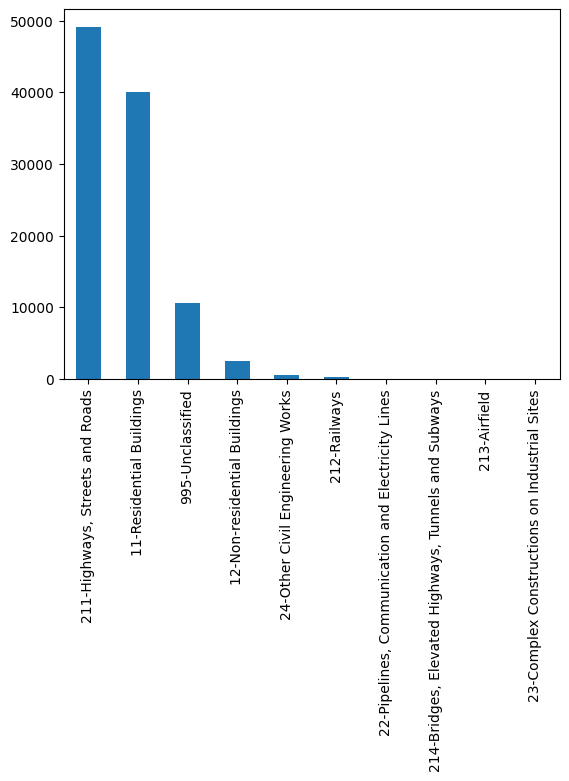

In [6]:
%matplotlib inline
data['obj_type'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.show()

In [7]:
def data_summary(df):
    """
    This function takes a DataFrame and prints the data types, number of missing values
    and percentage of missing values for each column.
    """
    summary = pd.DataFrame(df.dtypes, columns=['Dtype'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','Dtype']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Missing Percentage'] = (df.isnull().sum().values / df.shape[0]) * 100
    summary['Distinct Count'] = df.nunique().values
    return summary

data_info = data_summary(data)
data_info

,Column,Dtype,Missing,Missing Percentage,Distinct Count
0,obj_type,object,0,0.000000,10
1,name,object,10,0.009703,5082
2,info,object,0,0.000000,52
3,damage_gra,object,0,0.000000,5
4,or_src_id,int64,0,0.000000,6
5,dmg_src_id,int64,0,0.000000,4
6,area_id,object,0,0.000000,19
7,locality,object,0,0.000000,19
8,population,int64,0,0.000000,17
9,income,int64,0,0.000000,7


In [8]:
def remove_duplicates(df):
    """
    This function takes a DataFrame and returns a new DataFrame with duplicate rows removed.
    """
    print("Before removing duplicates, number of rows: ", df.shape[0])
    
    # Remove duplicates
    df = df.drop_duplicates()
    
    print("After removing duplicates, number of rows: ", df.shape[0])
    
    return df


data = remove_duplicates(data)

Before removing duplicates, number of rows:  103063
After removing duplicates, number of rows:  98794


    Exploring Variables:
### 1. obj_type, name, info:

The variables presented categorize the buildings, providing various levels of detail. For instance, the 'name' attribute tends to contain more nuanced information (as is the case with identifying a building as a school), whereas the 'obj_type' attribute generally offers less granularity in its classification. The anticipation is that these variables may have a high degree of correlation. Incorporating all of them in our model could potentially lead to multicollinearity or overfitting issues. It's crucial to approach this with care to ensure the integrity and reliability of our model's results.

info category seems to have variables that are wrongly created. To keep this we will manipulate the data and align with the building code and its value.

### 2. damage_gra : 

This variable is the target variable. Using geographic and socioeconomic variables, we can analyze how buildings behaved after the earthquake. According to pandas profile report we can see that this is an unbalanced variable that most of the buildings, facilities or roads are not damaged.

In order this variable to be used in any algorithm we should change it to numerical form. the level of damage can be clasified as ordinal categoric variable. 

### 3. dmg_src_id, or_src_id :

These variables are not meaningful and not explained in detail. It is infered as they are identifying variables, we do not need them in machine learning models.

### 4. locality, area_id :

Variables that explain the local we are observing. Both are them has 19 different locals as we are examining these areas. Both should be clasified as categoric variables. area_id is identifying variable.


### 5. Variables that were received from Turkstat:

More detailed info could be found in previous notebook. Data is added in the previous notebook manually. Some of the values are belong to province mean, therefore more than one locality might have the same score.

    population: Population of 2022
    income: Income in USD for 2022
    total_sales : total house sales in the last 5 years
    second_sales : second hand house sales in the las 5 years ( this might be interesting because these buildings expectedto be more risky than the new ones)
    water_access : percentage of access to city water
    elec_cons : electric consumption of per capita
    building_perm: number of buildings permited
    land_perm : land permited in the province in m2
    labour_fource: labour force participation rate in the local 2022
    unemployment : uneployment rate 2022
    agricultural : agricultural area in decares.
    life_time : expected lifetime
    hb_per1000000 : hospital beds in the province per 100000
    fertility : fertility rate
    hh_size : average household size in the area


### 6. Geospatial Variables:

Variables that have a geographic meaning. Latitude longitude was extracted from points or centroid of the polygon building. distance variables are created with BallTree methtod calculating Euclidian distance. In a geographic model as we have here if we are suspecting about some of them might be the reason for the target, we can calculate these variables as calculated previously. 



In [9]:
# Manipulations to the data:

#to info variable:

map_info = {'122':'122-Office buildings',
       '123':'123-Wholesale and retail trade buildings',
       '1251':'1251-Industrial buildings',
       '1263':'1263-School, university and research buildings',
       '1272':'1272-Hospital buildings',
       '1279':'1279-Military',
       '1280':'1280-Cemetery',
       'None' :'997-Not Applicable' }

data.info = data['info'].replace(map_info, inplace=True)

# to the target variable:
map_damage_gra = {'Damaged': 3,
                  'Destroyed': 4,
                  'No visible damage' : 1,
                  'Not Analysed': 0,
                  'Possibly damaged':2 }

data['damage_gra'] = data['damage_gra'].replace(map_damage_gra)


data.drop(columns = ['name', 'area_id', 'or_src_id', 'dmg_src_id'], inplace = True)


As seen in the graphs, Kirikhan and Kahramanmaras have recorded most damaged and destroyed buildings.

accorrding to building types

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_for_damage_level(data, column, damage_level):
    """
    Plot the distribution for the given damage level.

    Parameters:
    - data: DataFrame containing the information.
    - damage_level: Column name that contains the damage levels.
    """

    grouped_data = data.groupby([column, damage_level]).size().reset_index(name='count')

    distinct_values = grouped_data[damage_level].unique()

    for value in distinct_values:
        filtered_data = grouped_data[grouped_data[damage_level] == value]

        # Sort the filtered_data by 'count' in descending order
        filtered_data = filtered_data.sort_values(by='count', ascending=False)

        # Create the plot
        plt.figure(figsize=(10,6))
        sns.barplot(
            data=filtered_data, 
            x=column, y='count', 
            color="gray", alpha=.6
        )

        plt.title(f"Graph for {damage_level}: {value}")
        plt.ylabel("Count")
        plt.xlabel(f"Building Damage with {column}")
        plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
        plt.show()



variables_of_interest = ['obj_type', 'info', 'locality']

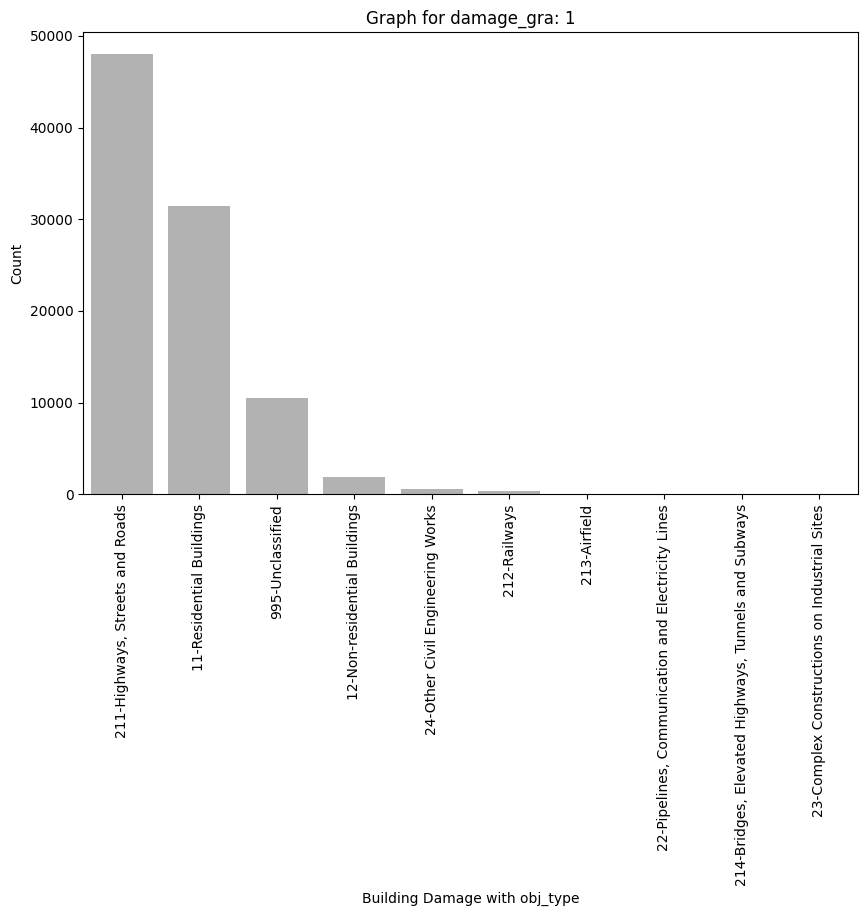

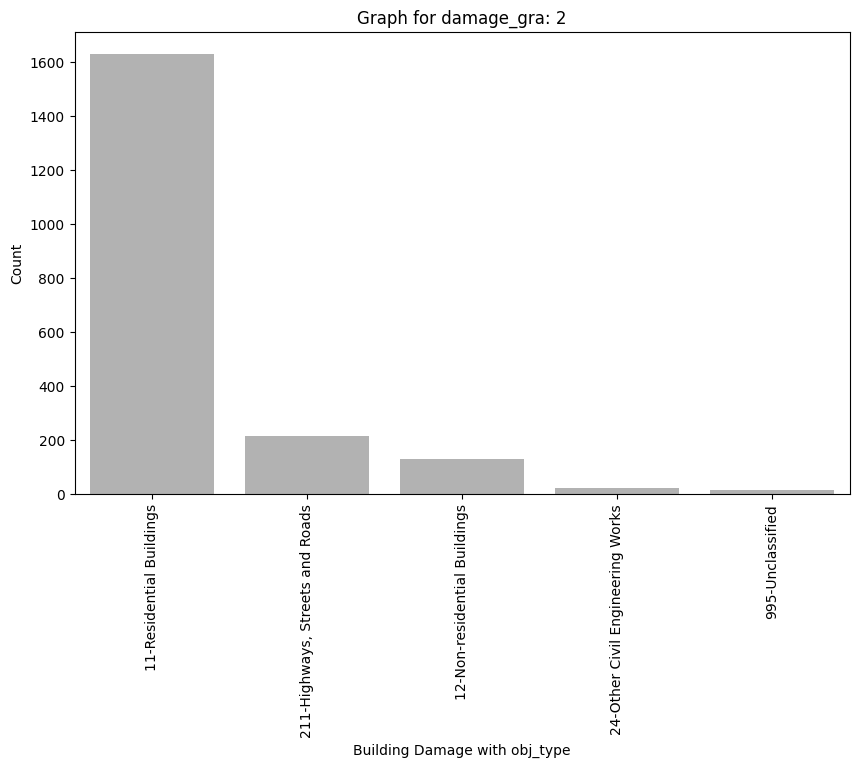

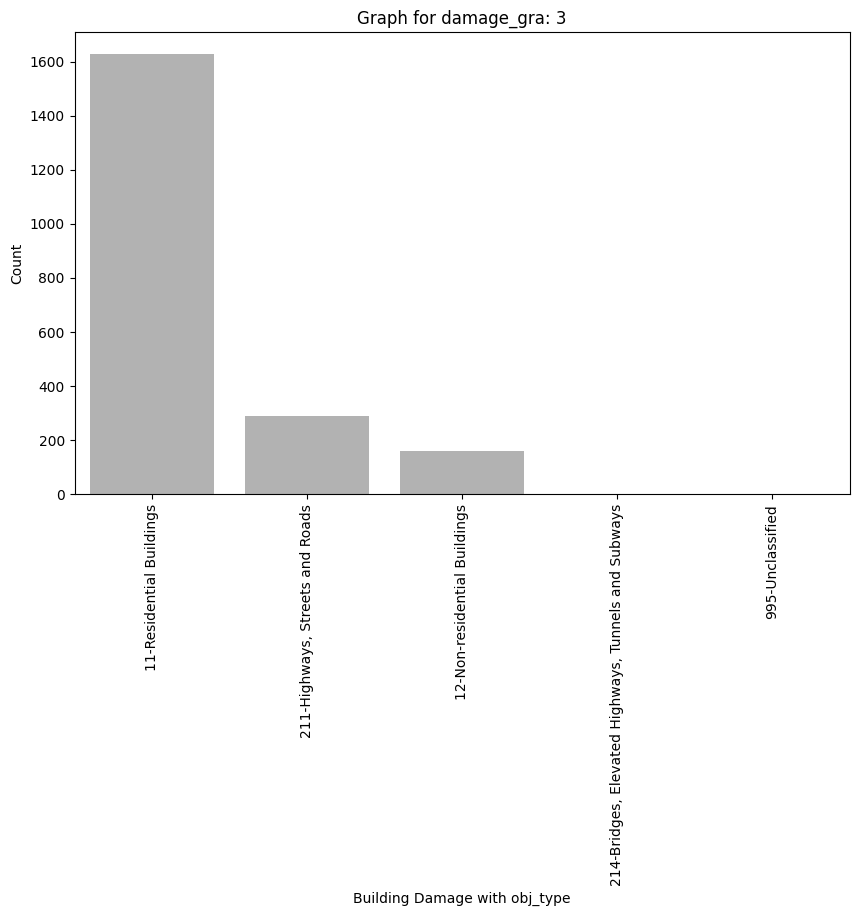

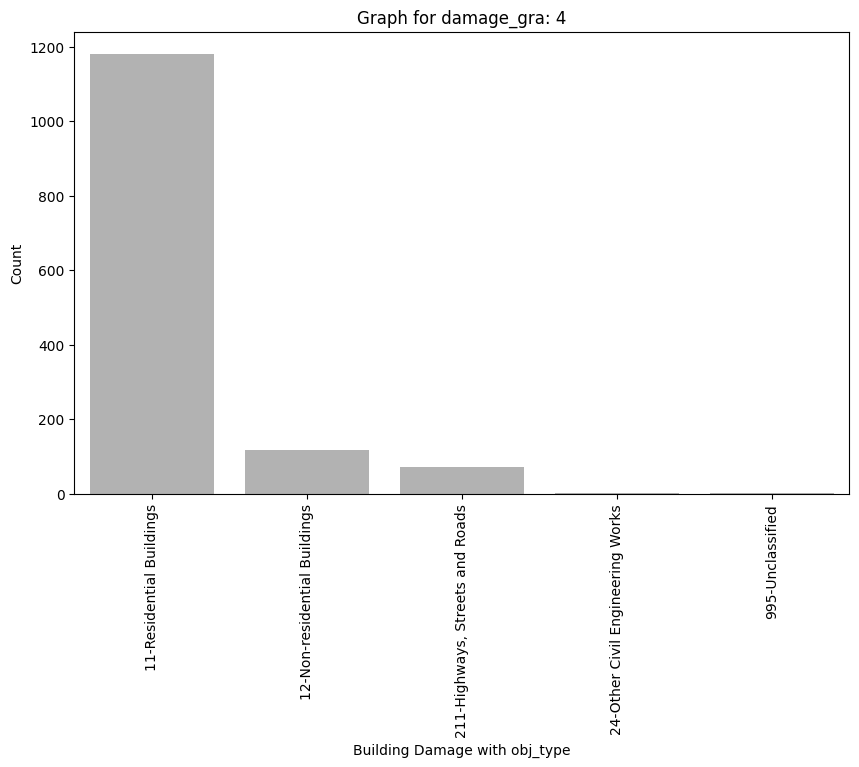

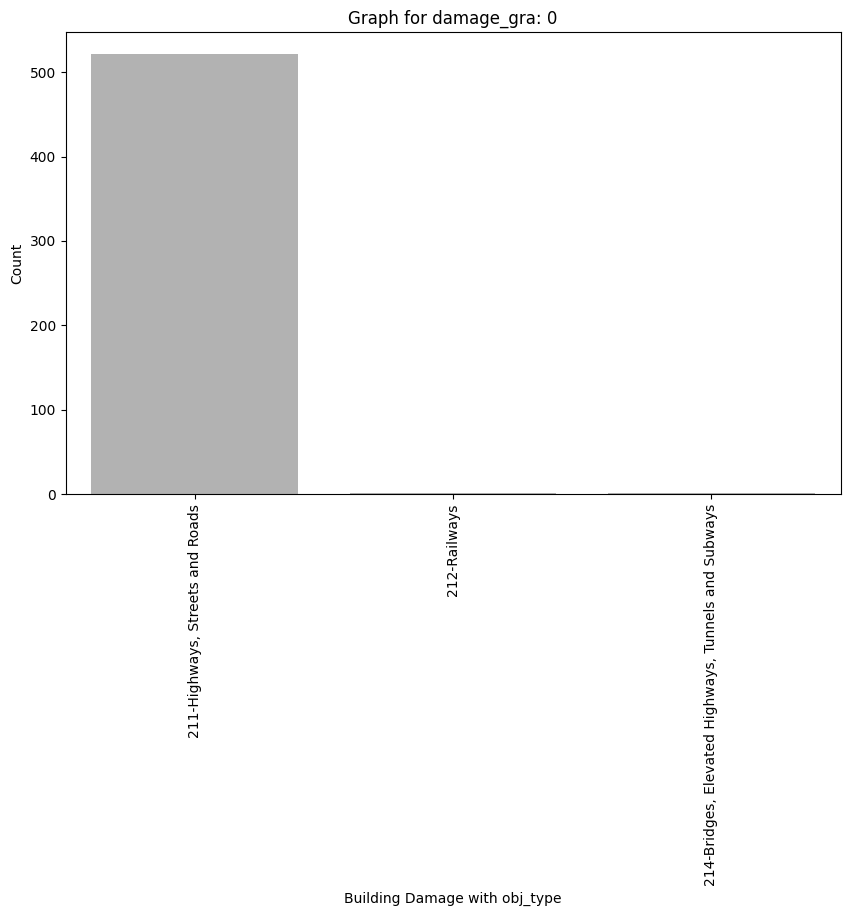

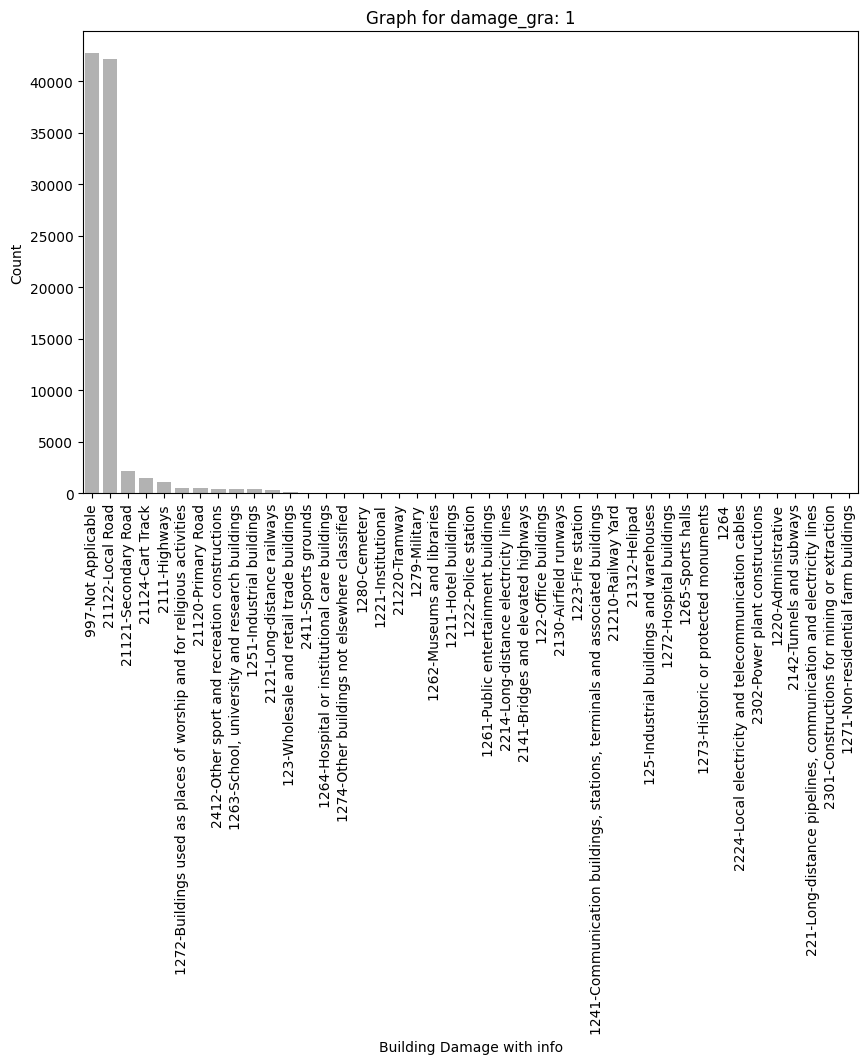

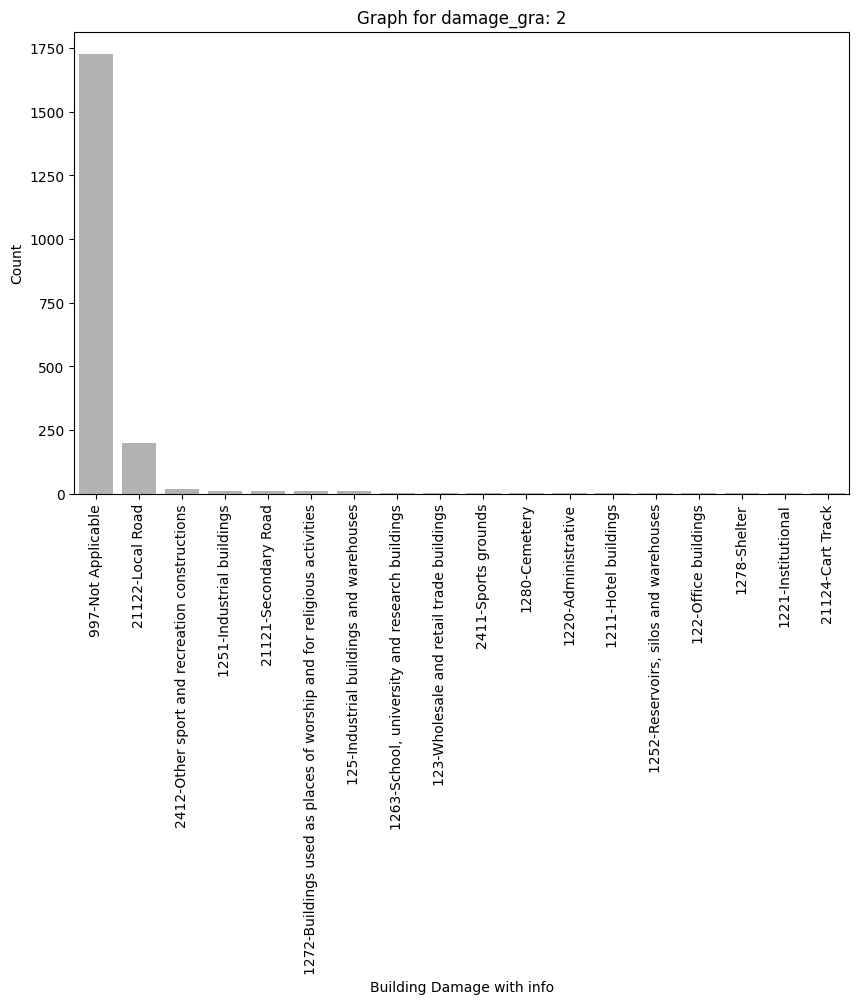

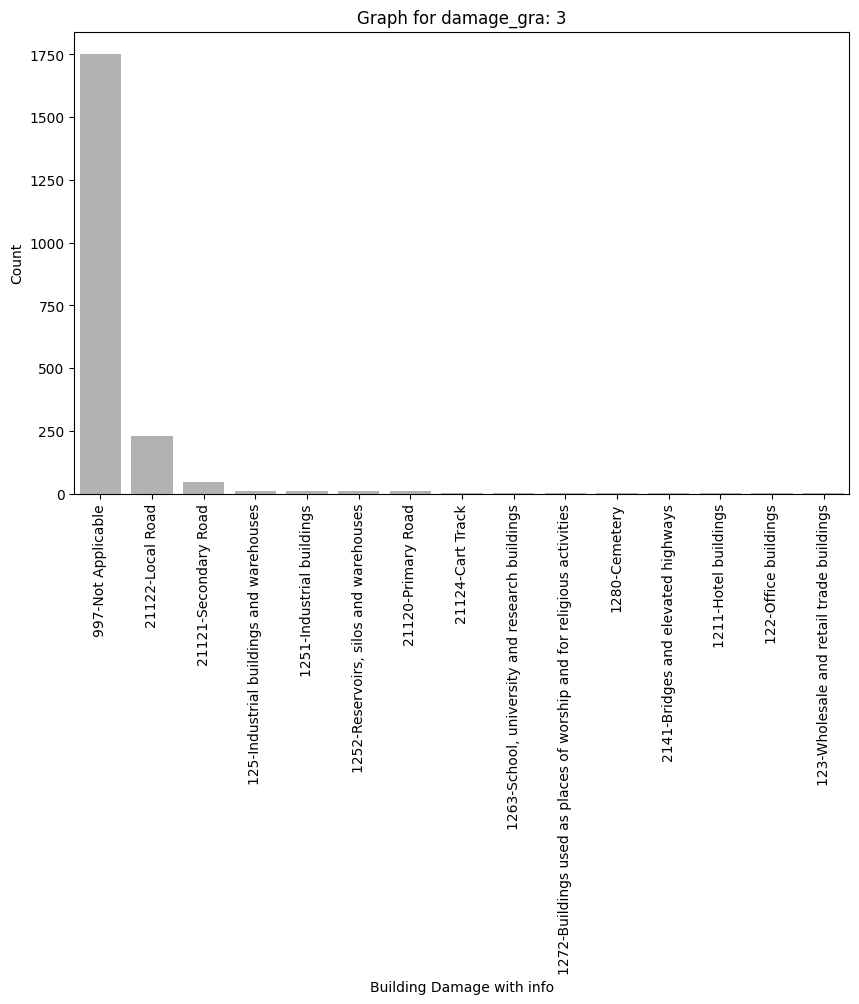

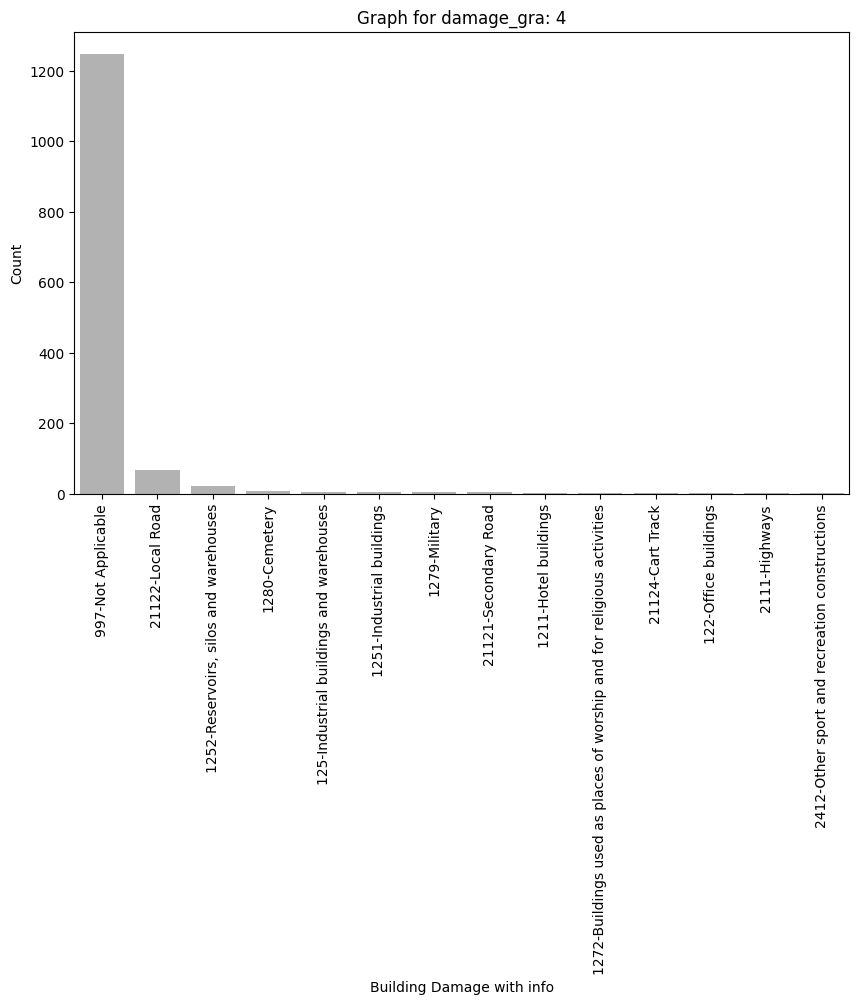

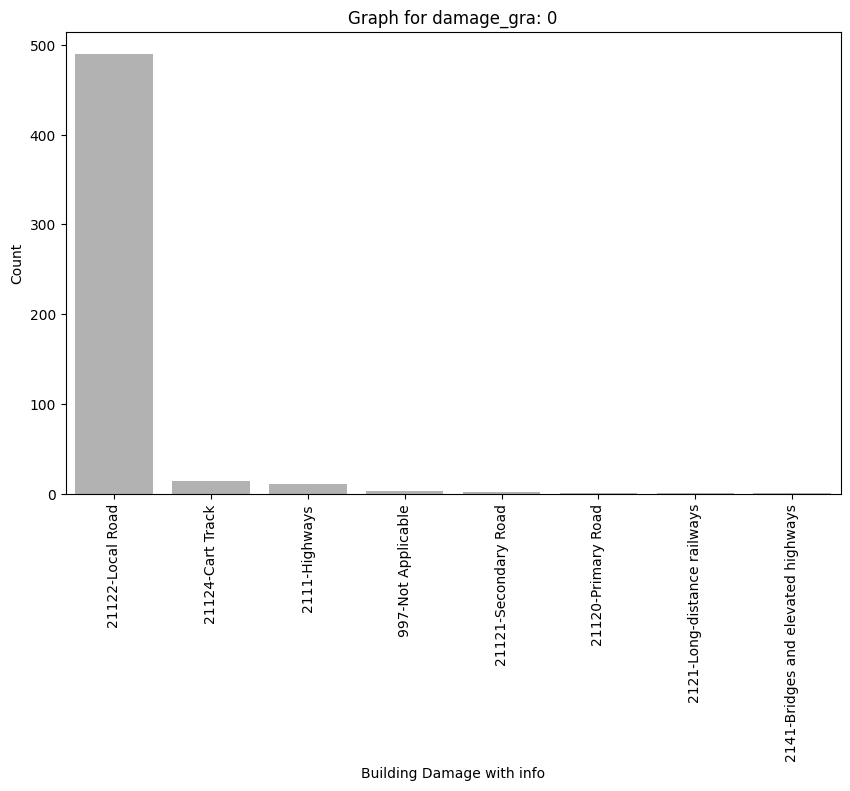

/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 159 (\x9f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


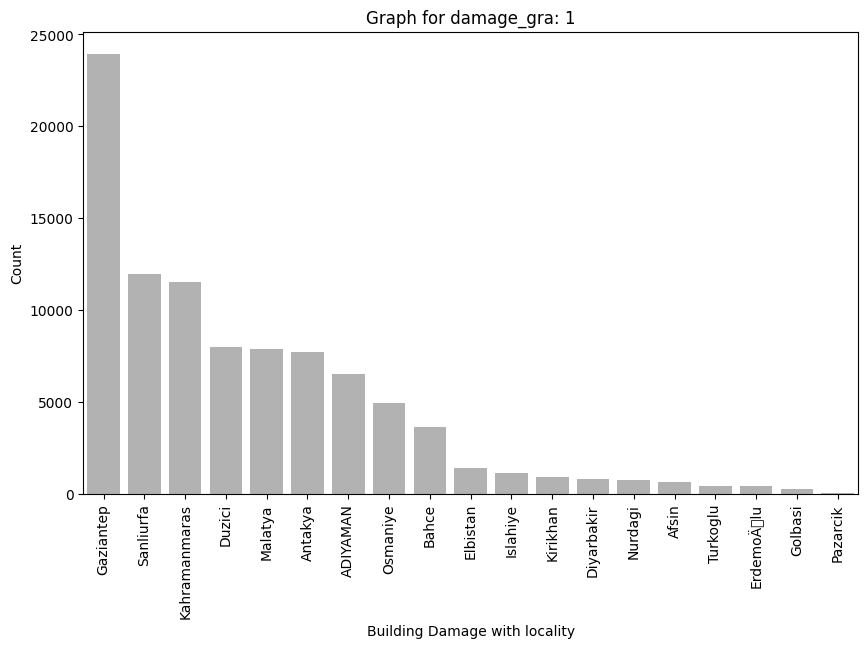

/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 159 (\x9f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


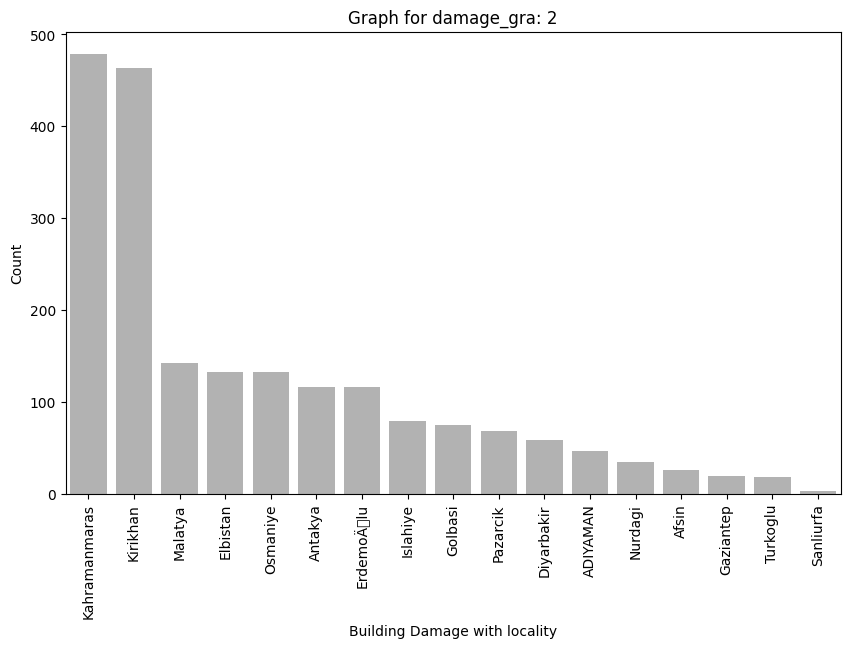

/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 159 (\x9f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


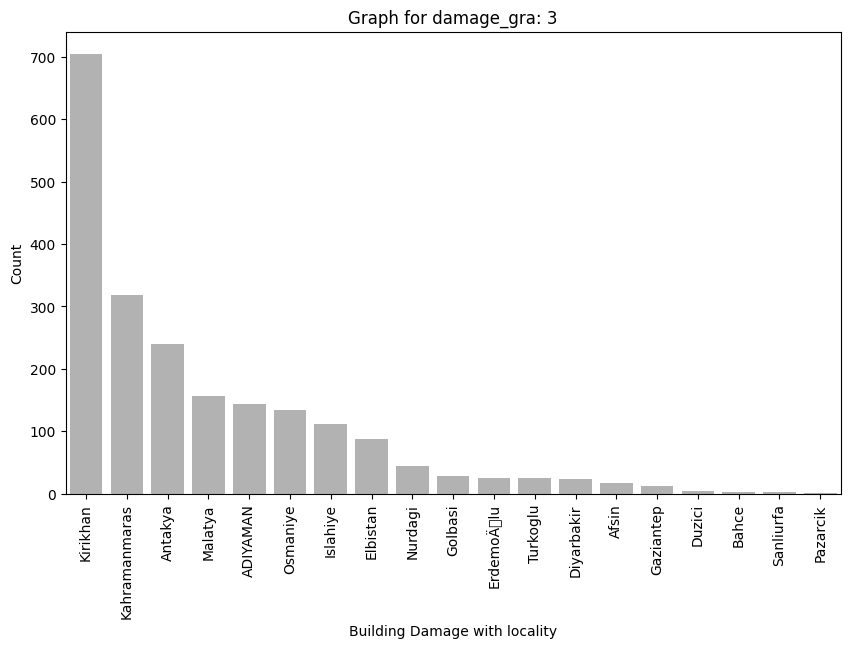

/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 159 (\x9f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


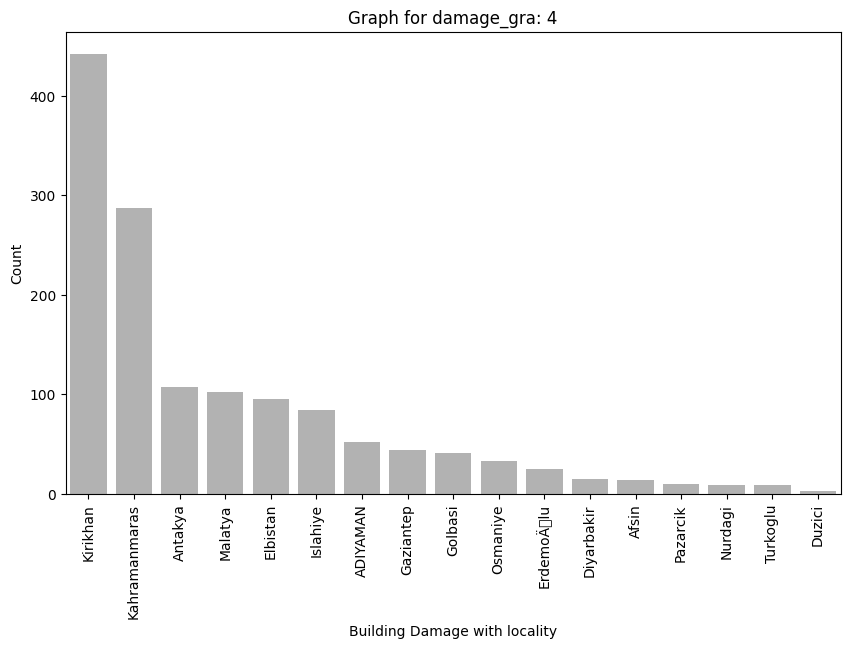

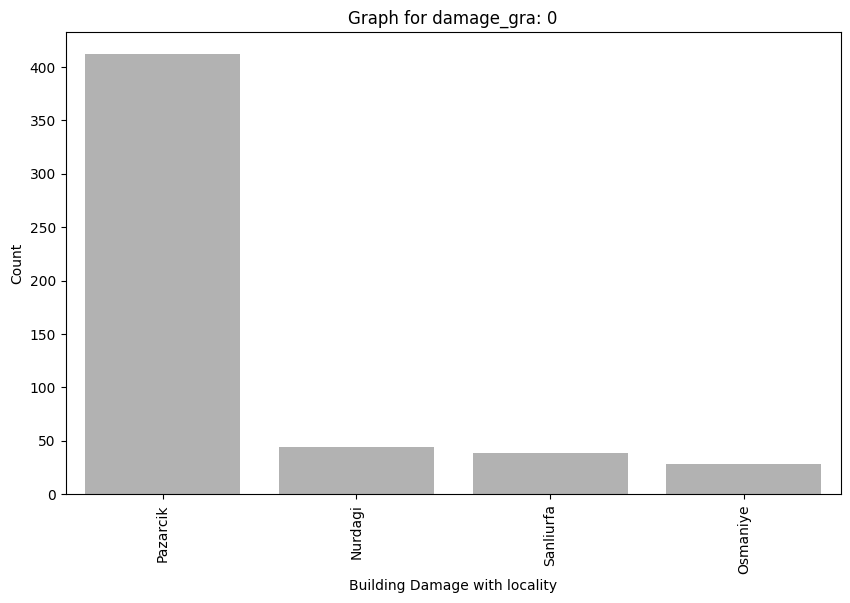

In [11]:
for variable in variables_of_interest:
    plot_for_damage_level(data, variable, 'damage_gra')
    

In [12]:
data

,obj_type,info,damage_gra,locality,population,income,total_sales,second_sales,water_access,elec_cons,...,fertility,hh_size,longitude,latitude,nearest_water_source_distance,nearest_camping_distance,nearest_earthquake_distance,nearest_fault_distance,elev,geometry
0,11-Residential Buildings,997-Not Applicable,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,2.36,4.00,38.314252,37.768867,0.077874,0.020232,0.097845,0.016935,660.0,POINT (38.31425 37.76887)
1,11-Residential Buildings,997-Not Applicable,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,2.36,4.00,38.313284,37.768690,0.076904,0.019284,0.097004,0.017440,660.0,POINT (38.31328 37.76869)
2,12-Non-residential Buildings,1251-Industrial buildings,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,2.36,4.00,38.318013,37.768612,0.081336,0.023588,0.100527,0.014585,660.0,POINT (38.31801 37.76861)
3,12-Non-residential Buildings,1251-Industrial buildings,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,2.36,4.00,38.318677,37.768575,0.081953,0.024196,0.101013,0.014241,660.0,POINT (38.31868 37.76857)
4,11-Residential Buildings,997-Not Applicable,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,2.36,4.00,38.312542,37.768514,0.076146,0.018542,0.096334,0.017826,660.0,POINT (38.31254 37.76851)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103058,212-Railways,997-Not Applicable,1,Turkoglu,78976,5997,1938,536,0.95,4343,...,1.99,3.68,36.857965,37.371851,0.194512,0.012611,0.000852,0.031609,500.0,POINT (36.85797 37.37185)
103059,212-Railways,997-Not Applicable,1,Turkoglu,78976,5997,1938,536,0.95,4343,...,1.99,3.68,36.858174,37.371509,0.194789,0.013011,0.000538,0.031945,500.0,POINT (36.85817 37.37151)
103060,212-Railways,997-Not Applicable,1,Turkoglu,78976,5997,1938,536,0.95,4343,...,1.99,3.68,36.858593,37.371981,0.194226,0.012857,0.001146,0.031466,500.0,POINT (36.85859 37.37198)
103061,212-Railways,997-Not Applicable,1,Turkoglu,78976,5997,1938,536,0.95,4343,...,1.99,3.68,36.857783,37.372028,0.194388,0.012364,0.001050,0.031438,500.0,POINT (36.85778 37.37203)


As seen in the graphs, roads are the group of building that have deteriorated the most.

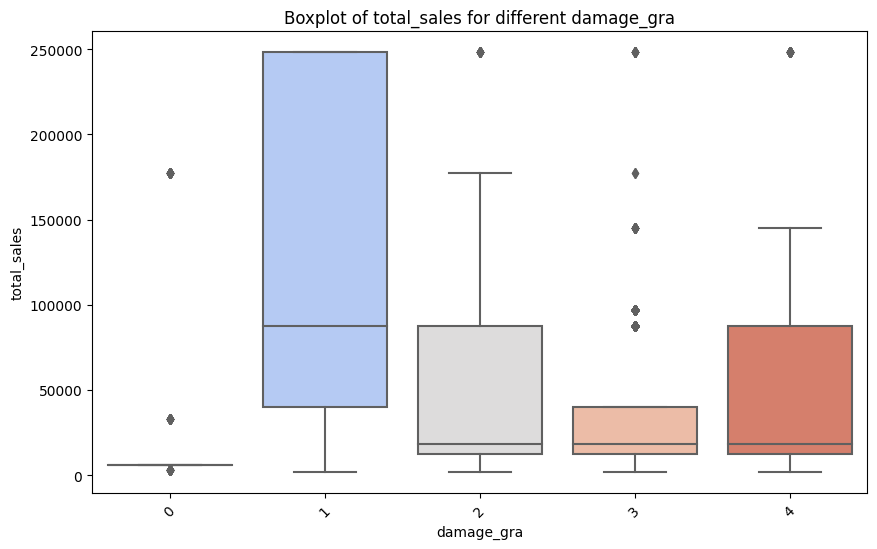

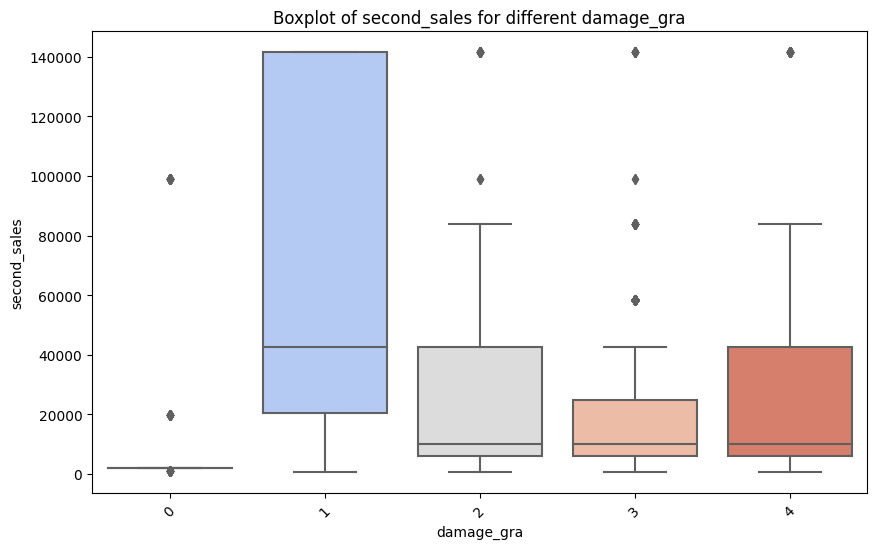

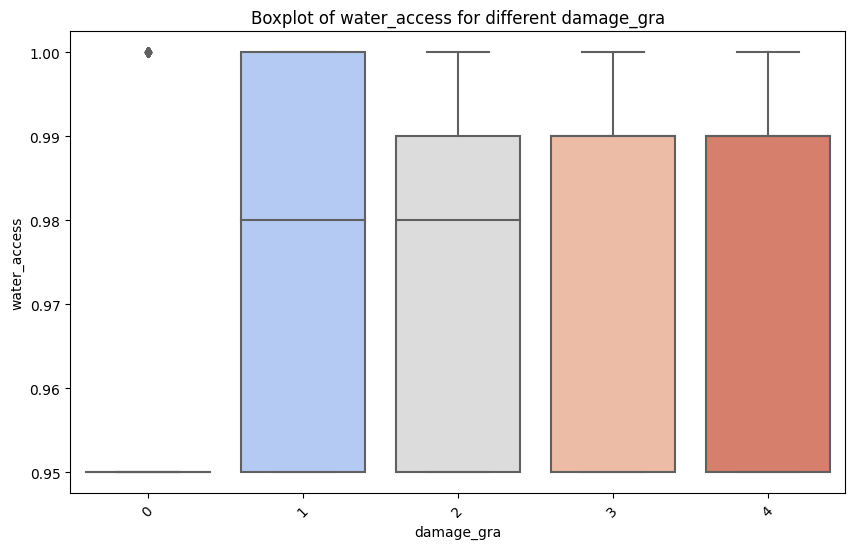

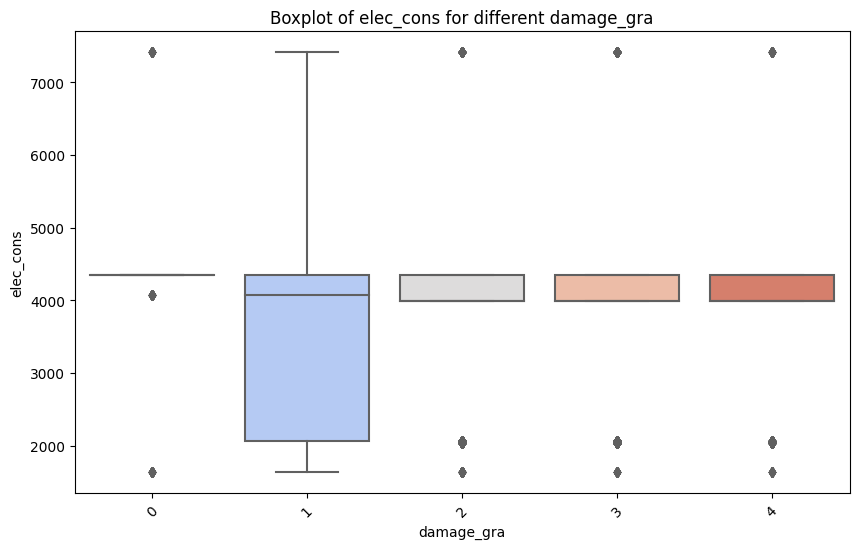

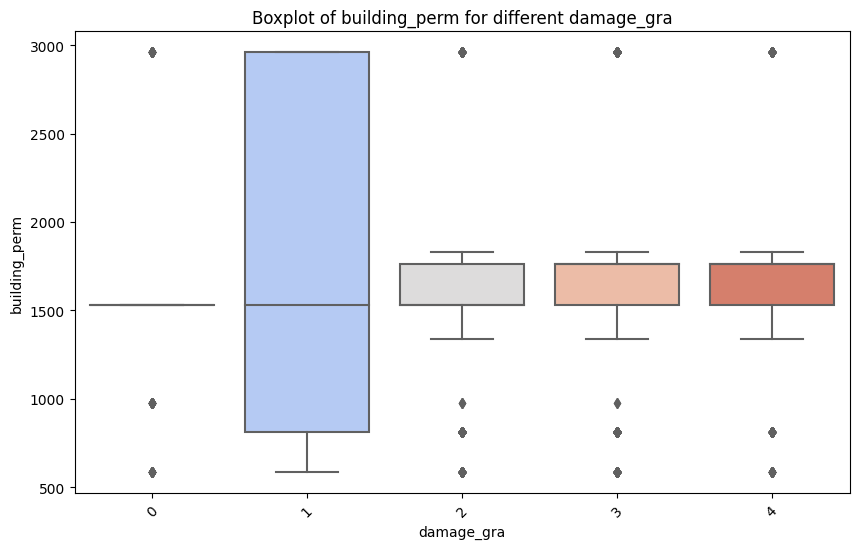

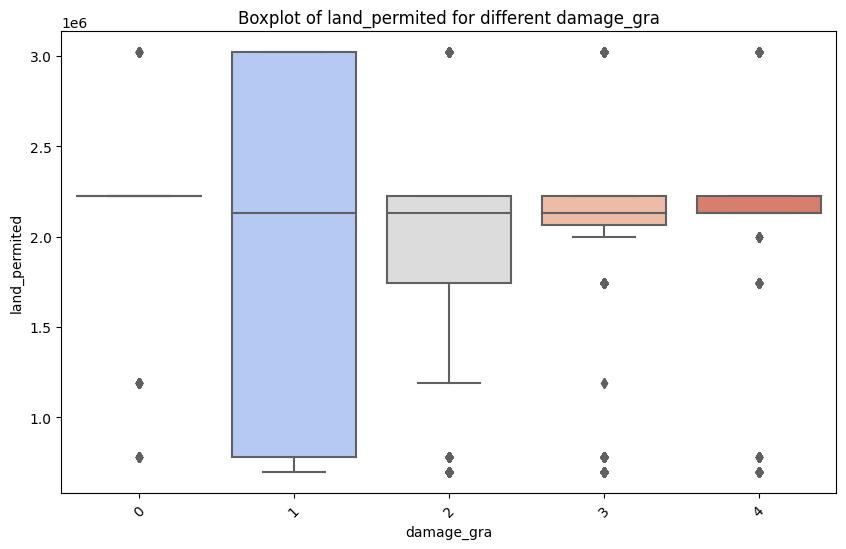

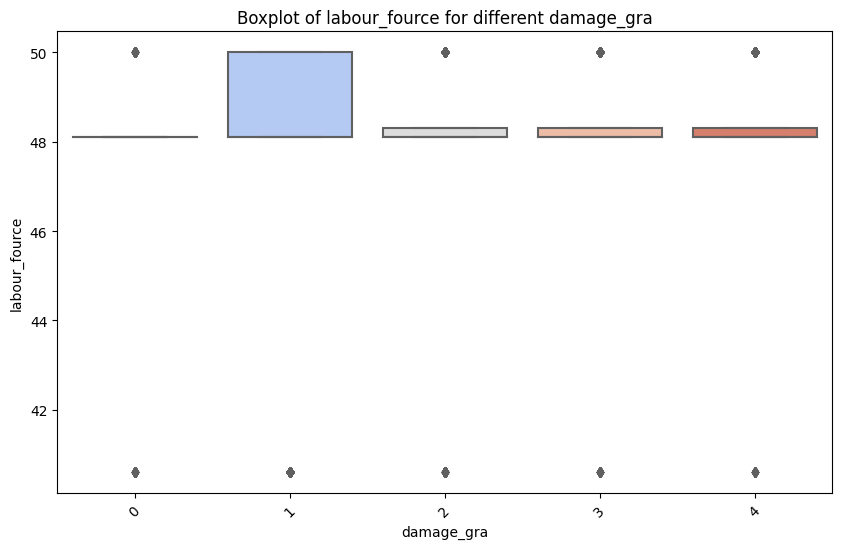

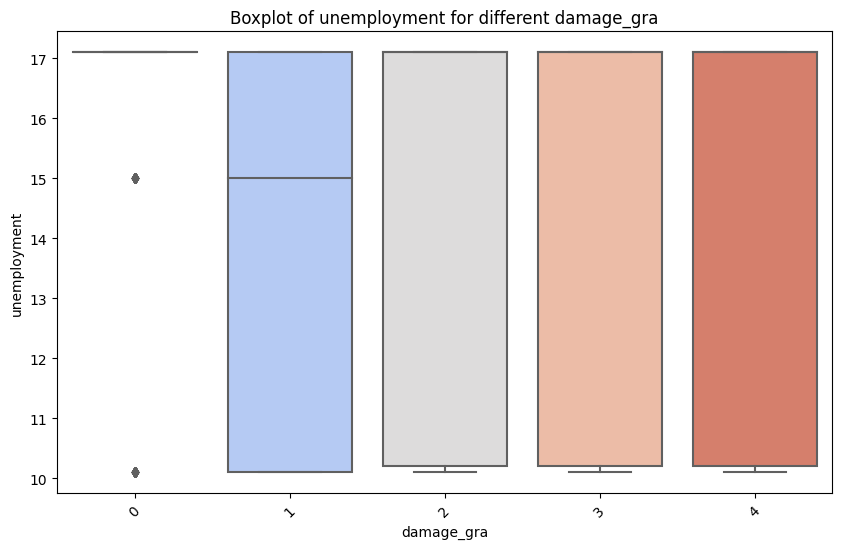

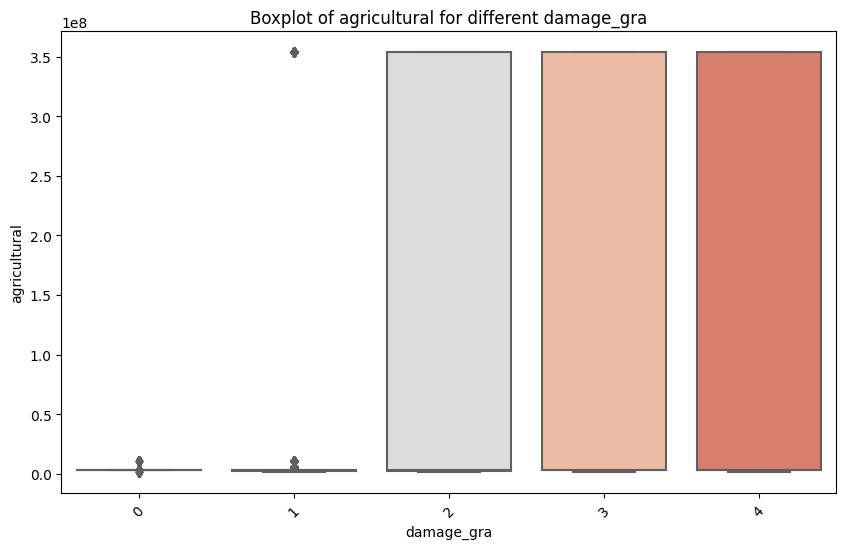

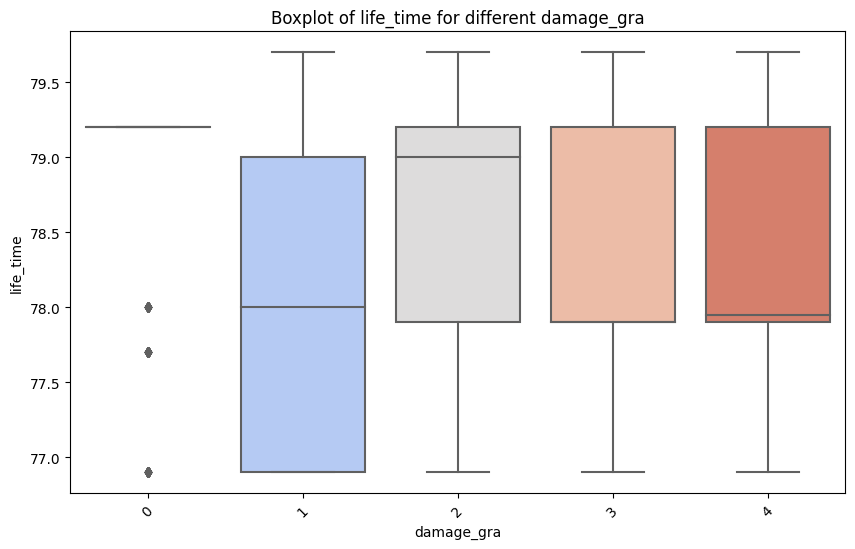

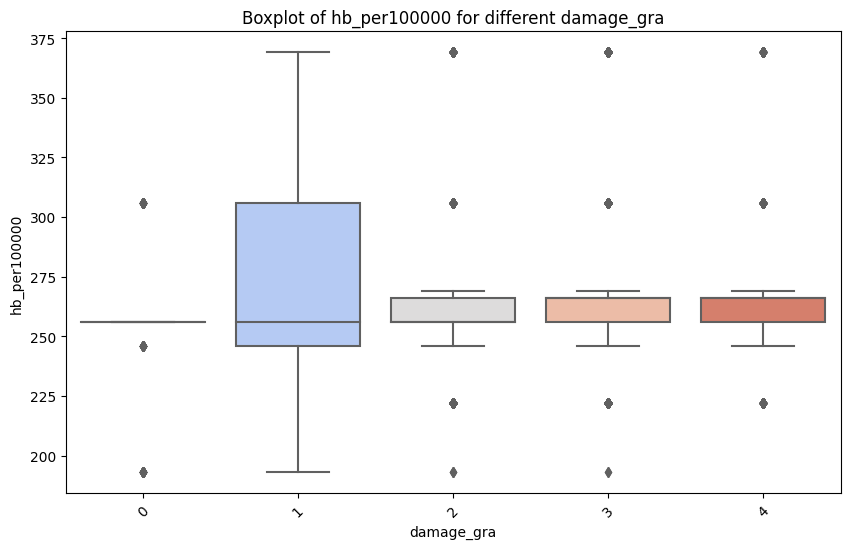

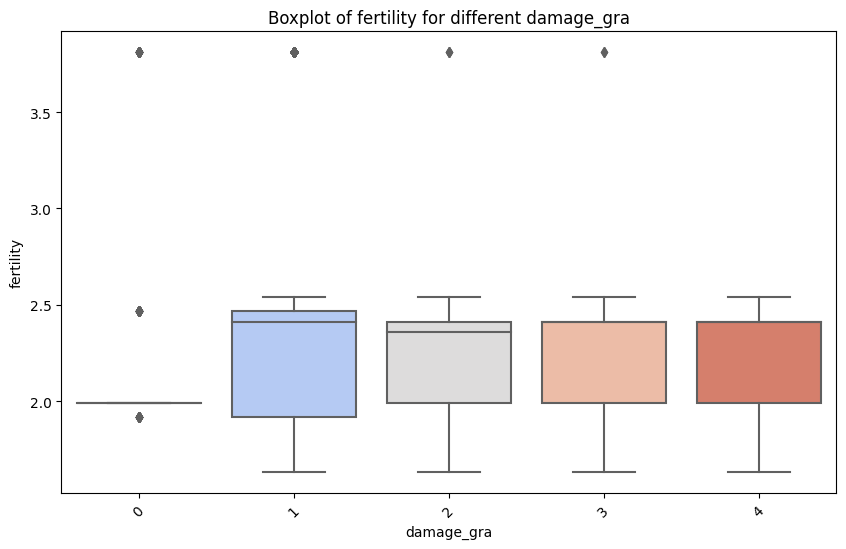

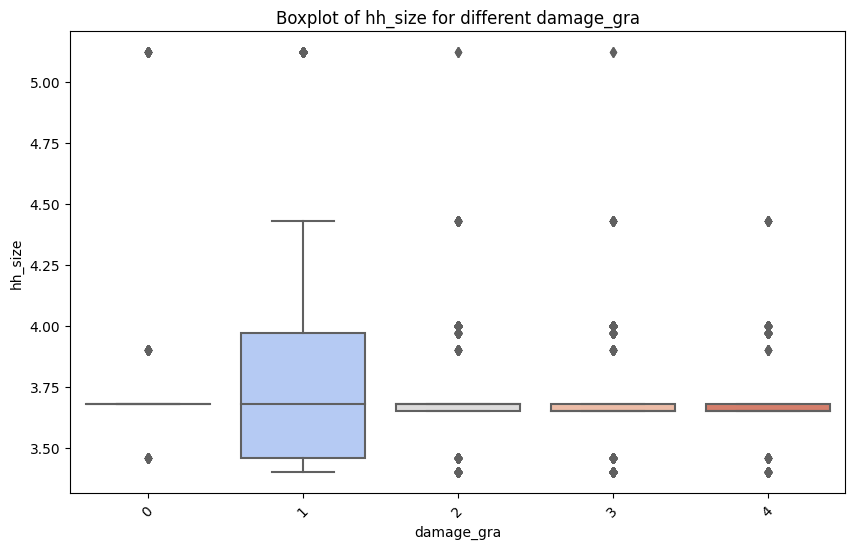

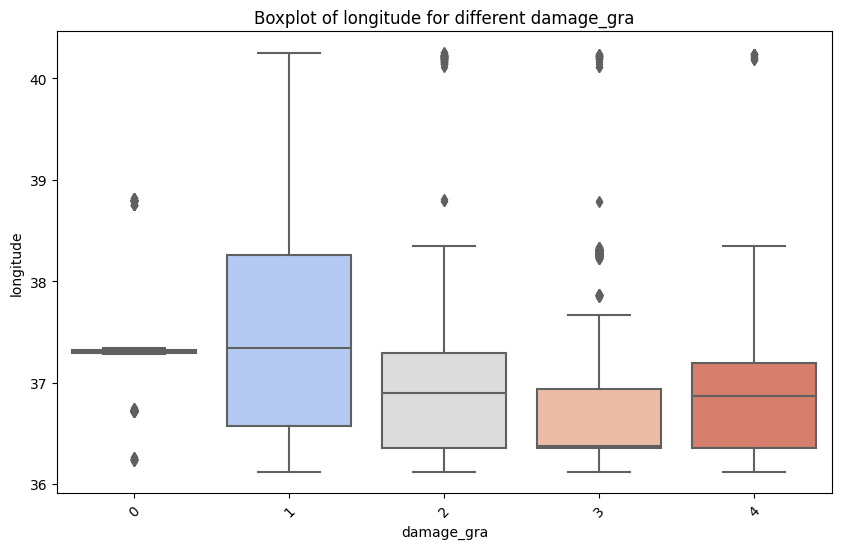

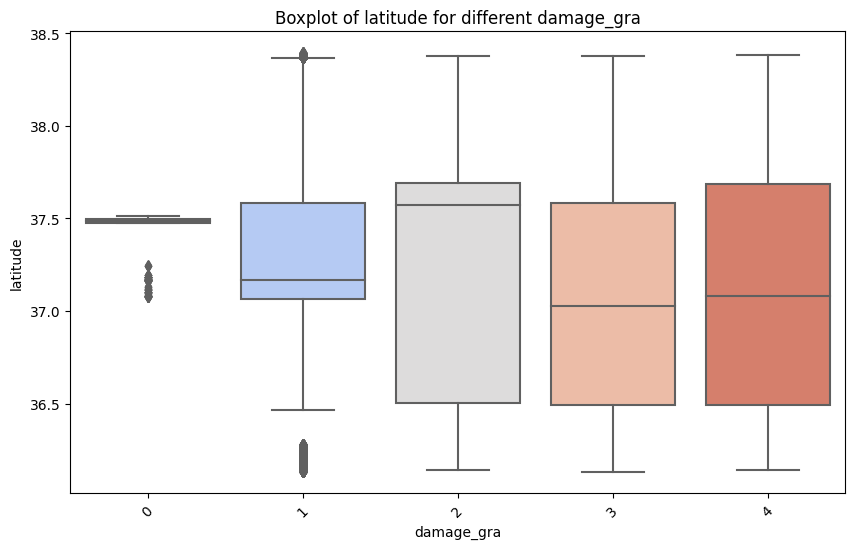

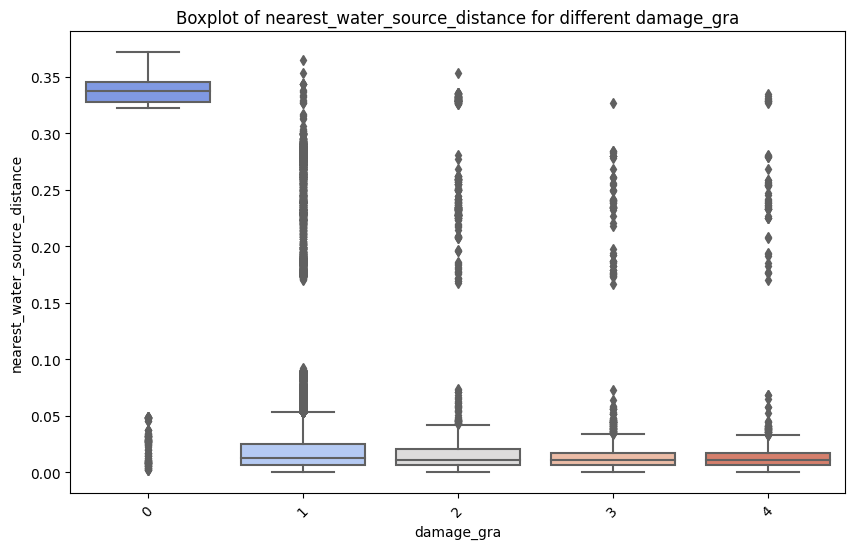

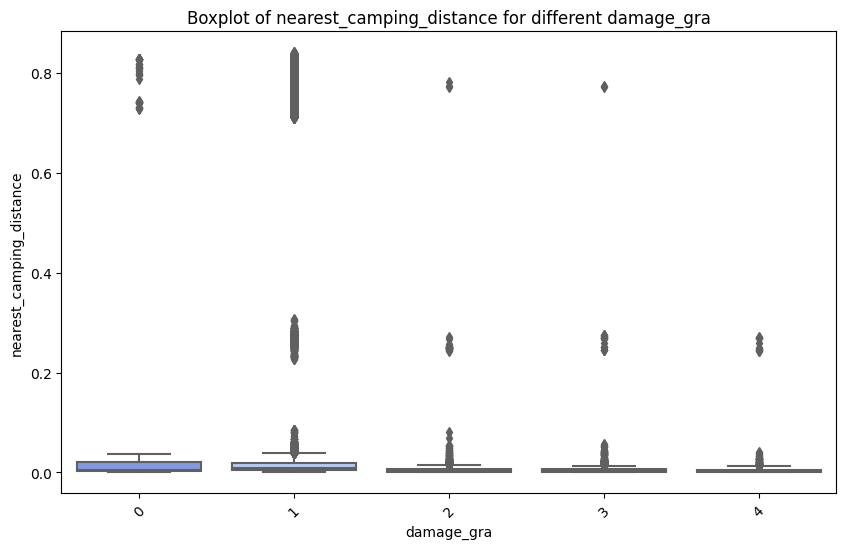

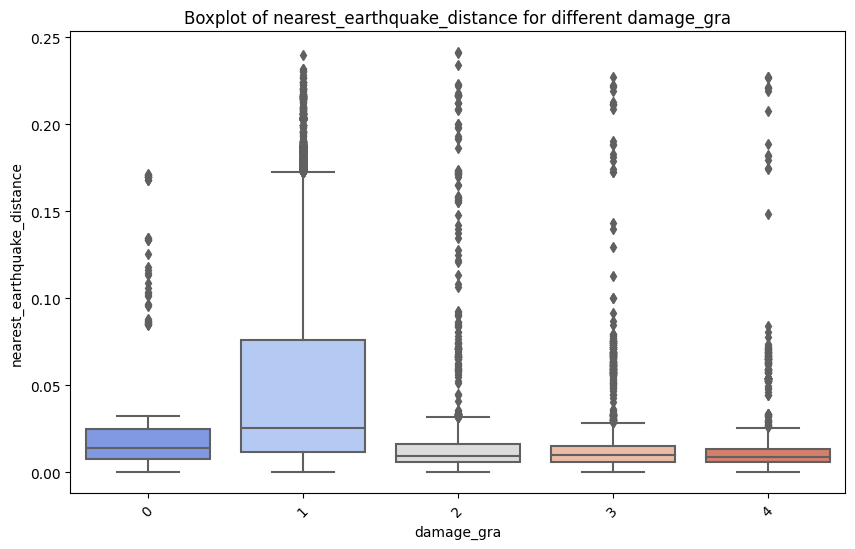

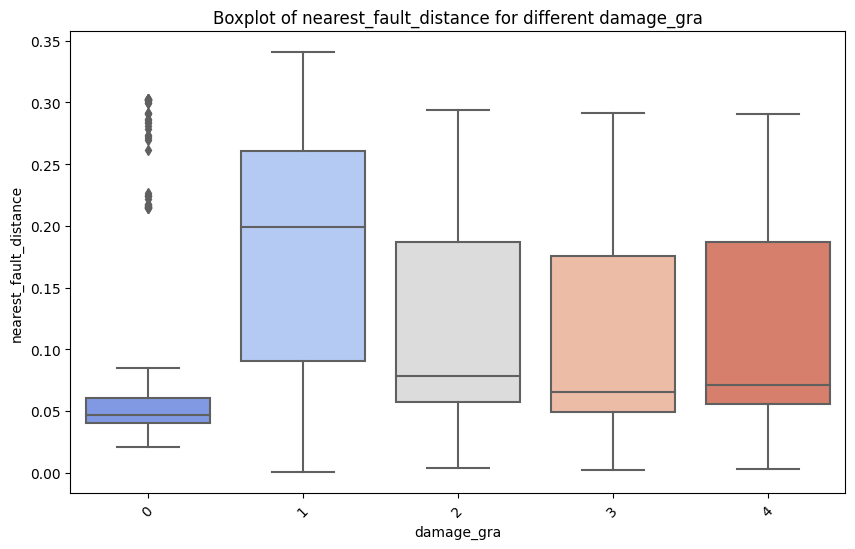

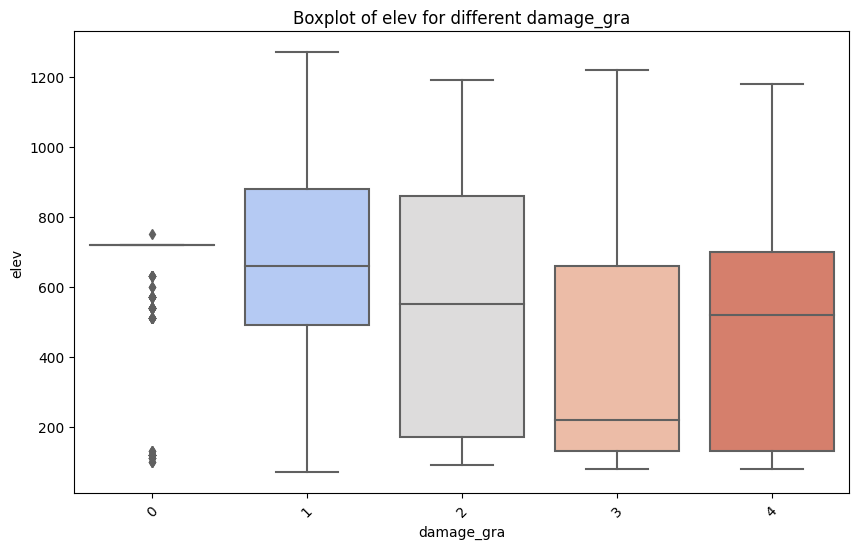

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_continuous_for_damage_level(data, column, damage_level):
    """
    Plot the distribution of a continuous variable for different damage levels using boxplots.

    Parameters:
    - data: DataFrame containing the information.
    - column: The name of the continuous column.
    - damage_level: Column name that contains the damage levels.
    """

    plt.figure(figsize=(10,6))
    
    sns.boxplot(
        data=data, 
        x=damage_level, 
        y=column, 
        palette="coolwarm"
    )

    plt.title(f"Boxplot of {column} for different {damage_level}")
    plt.ylabel(column)
    plt.xlabel(damage_level)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.show()

# Example usage:
# Assuming 'building_height' is a continuous variable and 'damage_status' is the target variable.
# plot_continuous_for_damage_level(data, 'building_height', 'damage_status')


continuous_columns = ['total_sales', 'second_sales', 'water_access', 'elec_cons',
       'building_perm', 'land_permited', 'labour_fource', 'unemployment',
       'agricultural', 'life_time', 'hb_per100000', 'fertility', 'hh_size',
       'longitude', 'latitude', 'nearest_water_source_distance',
       'nearest_camping_distance', 'nearest_earthquake_distance',
       'nearest_fault_distance', 'elev',]

for column in continuous_columns:
    plot_continuous_for_damage_level(data, column, 'damage_gra')

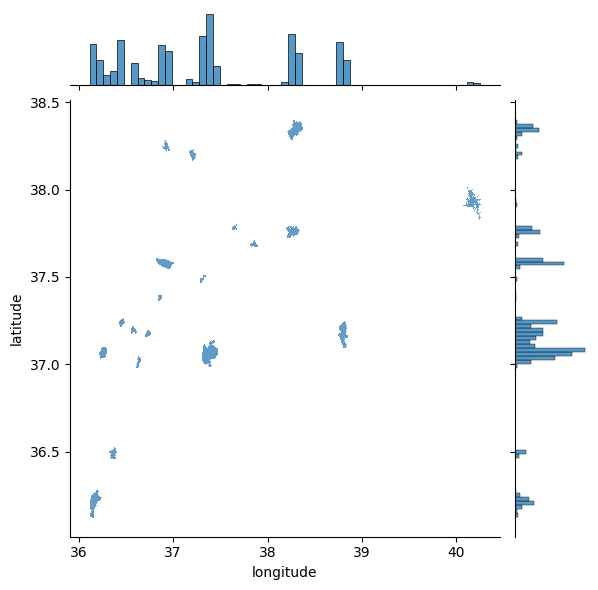

In [14]:
# Generate scatter plot
sns.jointplot(x="longitude", y="latitude", data=data, s=0.5);

/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 25 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


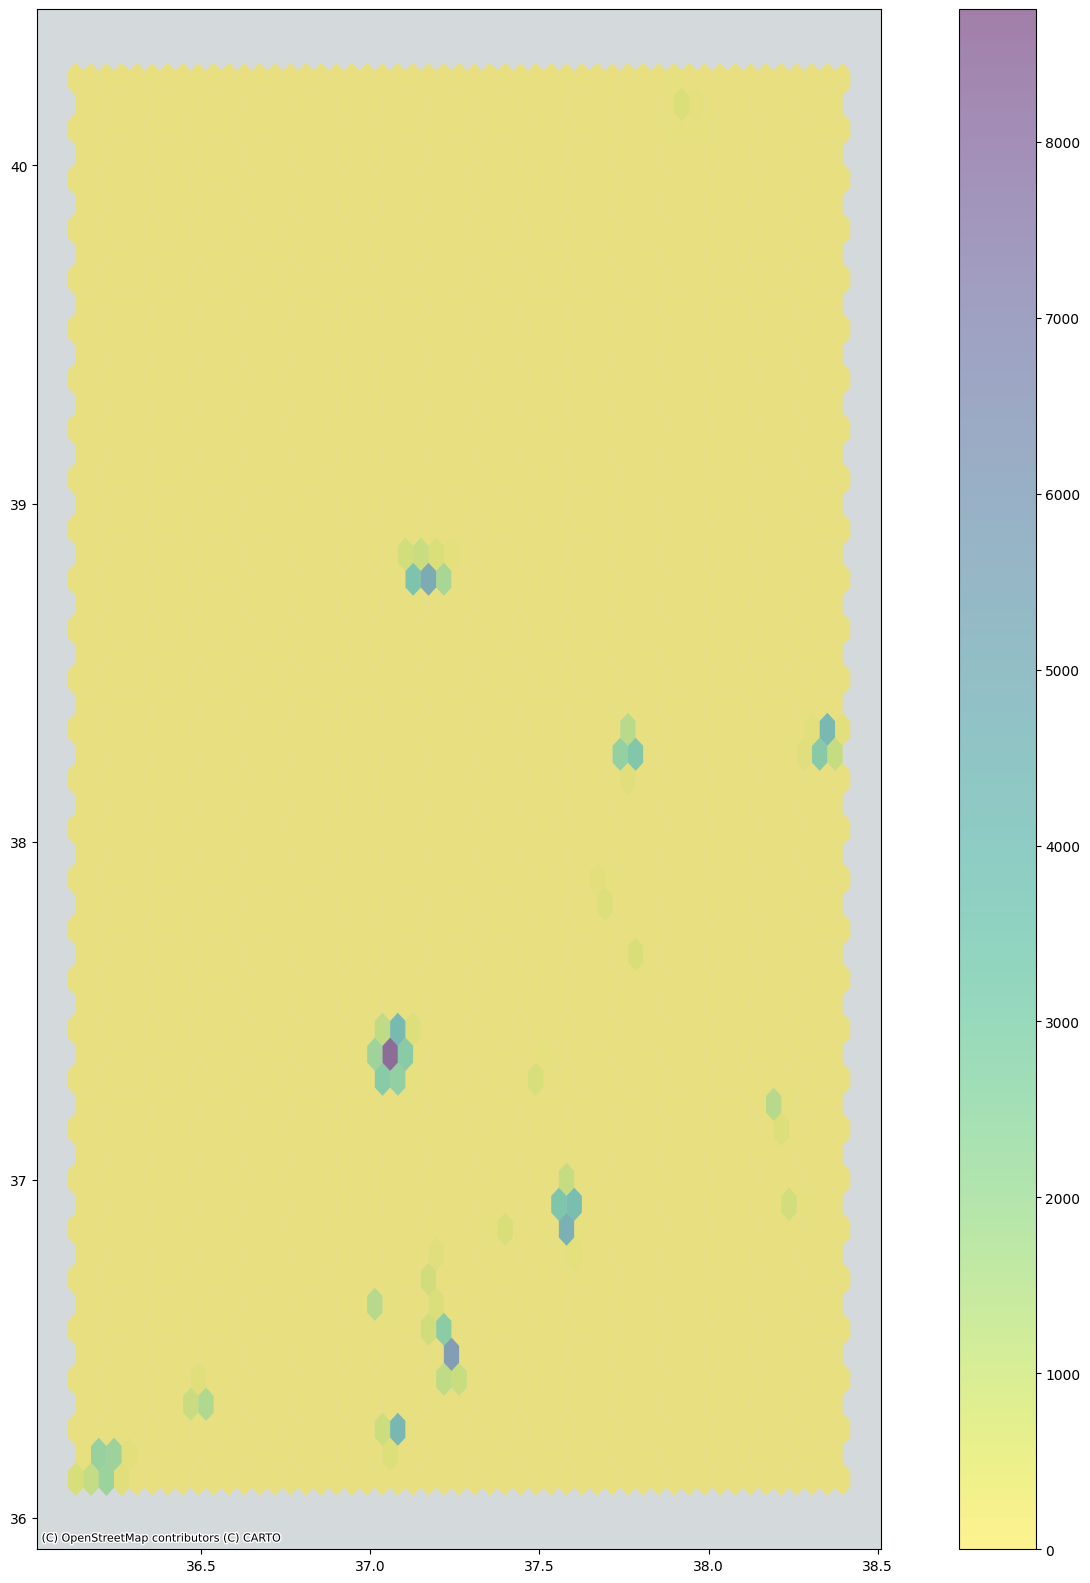

In [16]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(20, 20))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    data["latitude"],
    data["longitude"],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r",
)
# Add basemap
ctx.add_basemap(
    ax, source=ctx.providers.CartoDB.Positron
)
# Add colorbar
plt.colorbar(hb)


/tmp/ipykernel_120392/4158174324.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 25 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


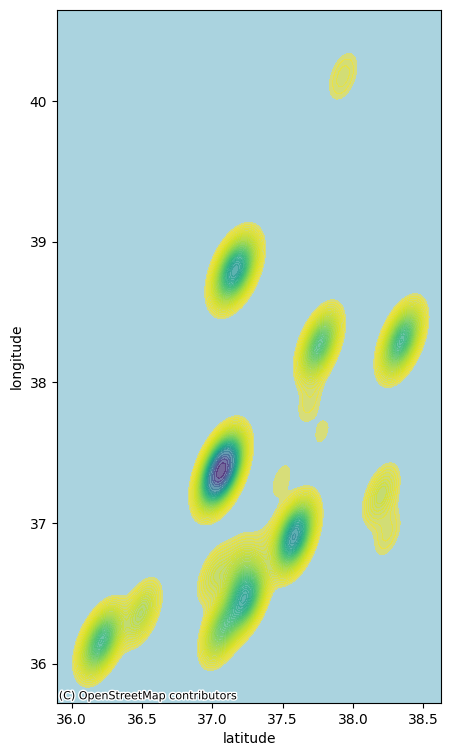

In [17]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
sns.kdeplot(
    x="latitude",
    y="longitude",
    data=data,
    n_levels=50,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Add basemap
ctx.add_basemap(
    ax, source=ctx.providers.OpenStreetMap.Mapnik
)

Now we can check the where are the damaged buildings and try to locate where they show more density.

Text(0.5, 1.0, 'Damaged and Destroyed buildings')

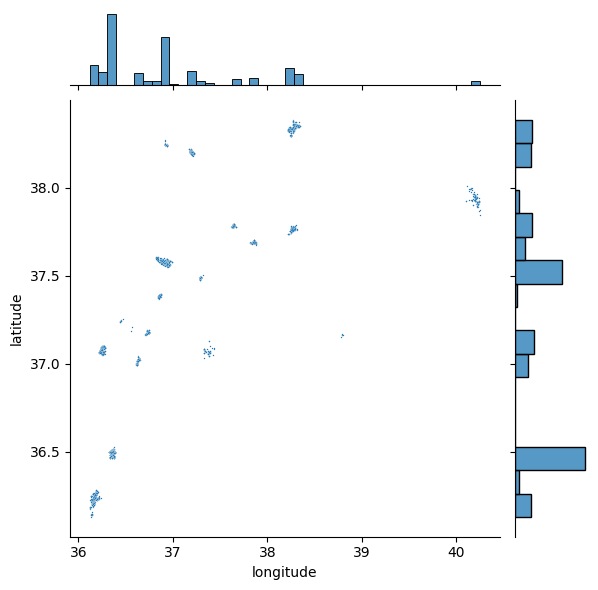

In [41]:
filtered_data = data[(data['damage_gra'] == 4) | (data['damage_gra'] == 3)| (data['damage_gra'] == 2)]



sns.jointplot(x="longitude", y="latitude", data=filtered_data, s=1);

# Set title
ax.set_title('Damaged and Destroyed buildings')

/tmp/ipykernel_120392/3045687701.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 25 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


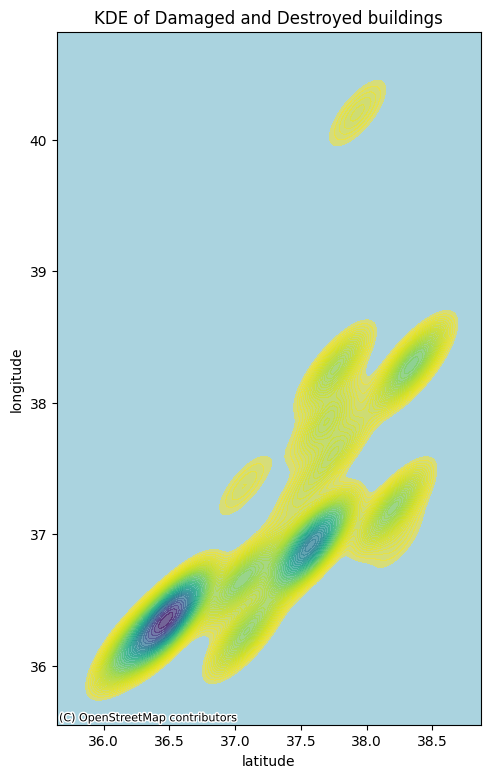

In [42]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
sns.kdeplot(
    x="latitude",
    y="longitude",
    data=filtered_data,
    n_levels=50,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Set title
ax.set_title('KDE of Damaged and Destroyed buildings')


# Add basemap
ctx.add_basemap(
    ax, source=ctx.providers.OpenStreetMap.Mapnik
)

Unnamed: 0	Date	longitude	latitude	Depth	Rms	Type	Magnitude	Location	EventID
0	0	2023-02-06 01:17:32	37.043	37.288	8.60	1.92	MW	7.7	Pazarcık (Kahramanmaraş)	543428
2	2	2023-02-06 01:28:16	36.920	37.304	6.20	0.21	MW	6.6	Nurdağı (Gaziantep)	543431
1	1	2023-02-06 10:24:47	37.239	38.089	7.00	0.58	MW	7.6	Elbistan (Kahramanmaraş)	543593
3	3	2023-02-20 17:04:27	36.021	36.037	21.73	0.94	MW	6.4	Yayladağı (Hatay)	551067

In [45]:

from pointpats import centrography
#calculating the mean center of the data destroyed and damaged data
mean_center_destroyeddamaged = centrography.mean_center(filtered_data[["latitude", "longitude"]])
med_center_destroyeddamaged = centrography.euclidean_median(filtered_data[["latitude", "longitude"]])
#calculating the mean center of all the data 
mean_center_data= centrography.mean_center(data[["latitude", "longitude"]])
med_center_data = centrography.euclidean_median(data[["latitude", "longitude"]])

Pazarcik_point = 37.288, 37.043	
Nurdagi_point = 37.304, 36.920
elbistan_point = 38.089, 37.239


/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 25 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


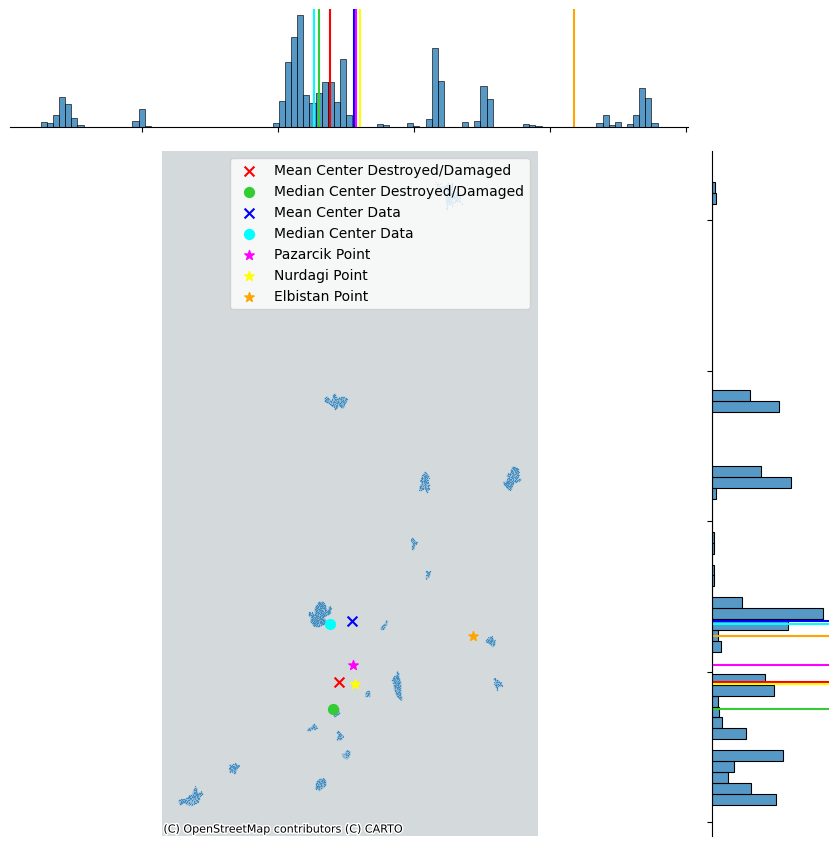

In [46]:


# Generate scatterplot
joint_axes = sns.jointplot(
    x="latitude", y="longitude", data=data, s=0.75, height=9
)

# Add points for destroyed and damaged data mean and median centers
for pt, color, marker, label in [
    (mean_center_destroyeddamaged, "red", "x", "Mean Center Destroyed/Damaged"),
    (med_center_destroyeddamaged, "limegreen", "o", "Median Center Destroyed/Damaged"),
    (mean_center_data, "blue", "x", "Mean Center Data"),
    (med_center_data, "cyan", "o", "Median Center Data"),
    (Pazarcik_point, "magenta", "*", "Pazarcik Point"),
    (Nurdagi_point, "yellow", "*", "Nurdagi Point"),
    (elbistan_point, "orange", "*", "Elbistan Point")
]:
    joint_axes.ax_joint.scatter(
        pt[0], pt[1], color=color, marker=marker, s=50, label=label
    )
    joint_axes.ax_marg_x.axvline(pt[0], color=color)
    joint_axes.ax_marg_y.axhline(pt[1], color=color)

# Legend
joint_axes.ax_joint.legend()

# Add basemap
ctx.add_basemap(
    joint_axes.ax_joint, source=ctx.providers.CartoDB.Positron
)

# Clean axes
joint_axes.ax_joint.set_axis_off()

# Display
plt.show()

#comment about foundings

In [48]:
centrography.std_distance(filtered_data[["latitude", "longitude"]])

1.0463344620571575

In [49]:
major, minor, rotation = centrography.ellipse(filtered_data[["latitude", "longitude"]])

/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 25 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


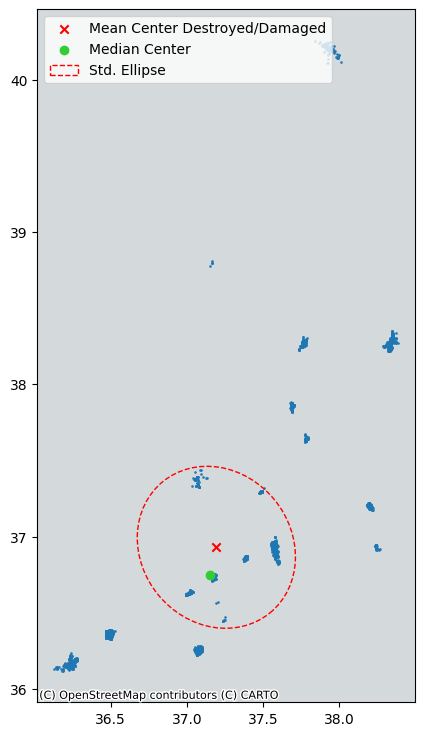

In [57]:
from matplotlib.patches import Ellipse

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot photograph points
ax.scatter(filtered_data["latitude"], filtered_data["longitude"], s=0.75)
ax.scatter(*mean_center_destroyeddamaged, color="red", marker="x", label="Mean Center Destroyed/Damaged")
ax.scatter(
    *med_center_destroyeddamaged, color="limegreen", marker="o", label="Median Center"
)

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(
    xy=mean_center_destroyeddamaged,  # center the ellipse on our mean center
    width=major * 2,  # centrography.ellipse only gives half the axis
    height=minor * 2,
    angle=np.rad2deg(
        rotation
    ),  # Angles for this are in degrees, not radians
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)
ax.add_patch(ellipse)

ax.legend()
# Display
# Add basemap
ctx.add_basemap(
    ax, source=ctx.providers.CartoDB.Positron
)
plt.show()

In [65]:
import libpysal

alpha_shape, alpha, circs = libpysal.cg.alpha_shape_auto(
    coordinates, return_circles=True
)


NameError: name 'coordinates' is not defined

In [60]:
# saving in geojson format (takes a while around 30 seconds)
# Infer the schema from your GeoDataFrame
schema = gpd.io.file.infer_schema(data)

with fiona.open("../data/processed/dataset2.geojson", 'w', 
                driver='GeoJSON', 
                crs='EPSG:4326', 
                schema=schema) as file:
    # Iterate over each row (record) in the GeoDataFrame
    for record in data.iterfeatures():
        file.write(record)

In [61]:
# incase of problems saving to the pickle file to be called from other notebooks.
with open('../data/processed/dataset2.pickle', 'wb') as f:
    pickle.dump(data, f)

In [63]:
# saving in geojson format (takes a while around 30 seconds)
# Infer the schema from your GeoDataFrame
schema = gpd.io.file.infer_schema(filtered_data)

with fiona.open("../data/processed/damaged_dataset.geojson", 'w', 
                driver='GeoJSON', 
                crs='EPSG:4326', 
                schema=schema) as file:
    # Iterate over each row (record) in the GeoDataFrame
    for record in filtered_data.iterfeatures():
        file.write(record)

In [64]:
# incase of problems saving to the pickle file to be called from other notebooks.
with open('../data/processed/damaged_dataset.pickle', 'wb') as f:
    pickle.dump(filtered_data, f)
    